In [2]:
from typing import Annotated, List
from langchain_openai import ChatOpenAI
from langchain.callbacks.tracers.langchain import wait_for_all_tracers
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

USER_AGENT environment variable not set, consider setting it to identify your requests.


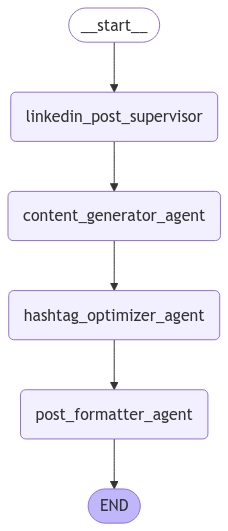

Here's your LinkedIn post formatted for optimal readability and engagement:

---

🚀 **At TechCorp**, we believe that **innovation drives success** in the rapidly evolving landscape of technology. 

Our enterprise AI solutions are designed to empower organizations to harness the full potential of AI for transformative results.

---

**Are you ready to elevate your business** with cutting-edge technology? 

👉 **Join us in the AI revolution!** 

👉 **Schedule a demo today** and see how we can help you innovate and lead in your industry.

---

#AI #Innovation #Technology #TechCorp #EnterpriseSolutions #FutureOfWork #ScheduleADemo #AIEmpowerment #DigitalTransformation #TechInnovation #BusinessGrowth #SmartTechnology #AIRevolution

---

This format uses line breaks for better readability, highlights key points for emphasis, and positions hashtags effectively at the end for visibility.


In [13]:
from typing import List, Dict, Literal, Optional
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState
from dataclasses import dataclass
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")

@dataclass
class PostConfig:
    """Configuration for LinkedIn post generation"""
    tone: str
    keywords: List[str]
    company_details: Dict[str, str]
    target_audience: str
    post_length: str
    industry: str
    call_to_action: Optional[str] = None

# Initialize your configuration
config = PostConfig(
    tone="professional and engaging",
    keywords=["AI", "innovation", "technology"],
    company_details={
        "name": "TechCorp",
        "industry": "AI Software",
        "value_proposition": "Enterprise AI solutions"
    },
    target_audience="Tech decision makers",
    post_length="short",
    industry="Technology",
    call_to_action="Schedule a demo"
)

# Content Generator Agent
def create_content_generator_agent(llm, config: PostConfig):
    system_prompt = f"""You are a professional LinkedIn content creator. Generate posts with the following specifications:
    - Tone: {config.tone}
    - Target Audience: {config.target_audience}
    - Industry: {config.industry}
    - Post Length: {config.post_length}
    - Keywords to include: {', '.join(config.keywords)}
    - Company Details: {config.company_details}
    
    Guidelines:
    1. Maintain consistent brand voice
    2. Include relevant hashtags
    3. Optimize for engagement
    4. Include a clear call-to-action: {config.call_to_action if config.call_to_action else 'Based on post context'}
    """
    
    # Use state_modifier to inject the system prompt
    return create_react_agent(
        llm,
        tools=[],  # No tools for now
        state_modifier=SystemMessage(content=system_prompt)  # Inject system prompt
    )

content_generator_agent = create_content_generator_agent(llm, config)

def content_generator_node(state: MessagesState):
    result = content_generator_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="content_generator_agent"
            )
        ]
    }

# Hashtag Optimizer Agent
hashtag_system_prompt = """You are a LinkedIn hashtag optimization specialist.
Your role is to analyze the post content and add relevant, trending hashtags that will maximize visibility.
Ensure hashtags are naturally integrated and don't overwhelm the post."""

hashtag_optimizer_agent = create_react_agent(
    llm,
    tools=[],  # No tools for now
    state_modifier=SystemMessage(content=hashtag_system_prompt)  # Inject system prompt
)

def hashtag_optimizer_node(state: MessagesState):
    result = hashtag_optimizer_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="hashtag_optimizer_agent"
            )
        ]
    }

# Post Formatter Agent
formatter_system_prompt = """You are a LinkedIn post formatting specialist.
Your role is to ensure the post follows LinkedIn best practices for formatting:
1. Use appropriate line breaks for readability
2. Ensure proper emoji placement
3. Format lists and bullet points effectively
4. Position hashtags optimally
5. Highlight key points using appropriate formatting techniques"""

post_formatter_agent = create_react_agent(
    llm,
    tools=[],  # No tools for now
    state_modifier=SystemMessage(content=formatter_system_prompt)  # Inject system prompt
)

def post_formatter_node(state: MessagesState):
    result = post_formatter_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="post_formatter_agent"
            )
        ]
    }

# LinkedIn Post Supervisor
def linkedin_post_supervisor_node(state: MessagesState):
    if "content_generator_agent" not in state:
        return {"goto": "content_generator_agent"}
    elif "hashtag_optimizer_agent" not in state:
        return {"goto": "hashtag_optimizer_agent"}
    elif "post_formatter_agent" not in state:
        return {"goto": "post_formatter_agent"}
    else:
        return {"goto": "END"}

# Build the graph
linkedin_post_builder = StateGraph(MessagesState)

# Add nodes
linkedin_post_builder.add_node("linkedin_post_supervisor", linkedin_post_supervisor_node)
linkedin_post_builder.add_node("content_generator_agent", content_generator_node)
linkedin_post_builder.add_node("hashtag_optimizer_agent", hashtag_optimizer_node)
linkedin_post_builder.add_node("post_formatter_agent", post_formatter_node)
linkedin_post_builder.add_node("END", lambda state: state)
# Add edges
linkedin_post_builder.add_edge("linkedin_post_supervisor", "content_generator_agent")
linkedin_post_builder.add_edge("content_generator_agent", "hashtag_optimizer_agent")
linkedin_post_builder.add_edge("hashtag_optimizer_agent", "post_formatter_agent")
#linkedin_post_builder.add_edge("post_formatter_agent", "linkedin_post_supervisor")
linkedin_post_builder.add_edge("post_formatter_agent", "END")

# Set the entry point
linkedin_post_builder.set_entry_point("linkedin_post_supervisor")

# Compile the graph
linkedin_post_graph = linkedin_post_builder.compile()
display(Image(linkedin_post_graph.get_graph().draw_mermaid_png()))
# Example usage
initial_state = MessagesState(messages=[])
result = linkedin_post_graph.invoke(initial_state)
print(result["messages"][-1].content)